<a href="https://colab.research.google.com/github/lleviraz/urban_segmentation/blob/main/notebooks/Regression_using_UNET_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of Residential and Non Residential Built-Up areas using UNET

(Sentienl2 satellite images with ESM masks)

Regression of the counts of the 4 classes instead of a pixel-wise segmentation

**TODOs:**
0. update the last layer to return the output for regression
1. Update loss function, and metrics to work with the output of channels x 4 numbers , counts of classes: 0,1,250,255

This notebook contains the Segmentation pipeline using fastai
It assumes that the dataset was already preprocessed and available 
in two directories:
- s2_resized - the input images
- esm_aligned - the ESM masks

It will create 3 new directories:
- s2_resized_test - test samples not used in training, nor validation
- esm_resized_test - masks of the above test images (unused)
- preds - predicted masks based on test data

By: Eli T. and Liad.L.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install fastai wwf nbdev rasterio geopandas fastbook tiffile imagecodecs pytorch-ignite -q
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf','fastbook','torch','torchvision','rasterio','pytorch-ignite'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, `wwf`, `fastbook`, `torch`, `torchvision`, `rasterio`, and `pytorch-ignite` currently running at the time of writing this:
* `fastai` : 2.6.0 
* `fastcore` : 1.4.2 
* `wwf` : 0.0.16 
* `fastbook` : 0.0.21 
* `torch` : 1.11.0+cu113 
* `torchvision` : 0.12.0+cu113 
* `rasterio` : 1.2.10 
* `pytorch-ignite` : 0.4.8 
---

In [ ]:
# Python General
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
import glob
from tqdm.notebook import tqdm
import pprint as pp
from PIL import Image
import numpy as np

#Torch
from torch import nn
import torch
import torch.nn.functional as F
from torchvision.transforms import *
from torchvision.transforms.functional import InterpolationMode
# from torchvision.models.resnet import resnet18,resnet34,resnet50,resnet101,wide_resnet50_2,resnext101_32x8d
from torchvision.models.resnet import resnet34,resnet50
#TODO try these two architechtures!!!
from torchvision.models.segmentation import deeplabv3_resnet50,fcn_resnet50
from ignite.metrics import SSIM


#rasterio
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
from rasterio.warp import calculate_default_transform, reproject, Resampling

#fastai
from fastcore.xtras import Path
from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos
from fastai.data import *
from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize
from fastai.layers import Mish
from fastai.losses import BaseLoss,DiceLoss,FocalLossFlat
from fastai.optimizer import ranger,Adam
from fastai.torch_core import tensor
from fastai.vision.all import *
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import unet_learner
from fastai.vision import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.basics import *

In [ ]:
import torch
import random
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' #GOOD FOR DEBUGGING
print('Using device:', device)

Using device: cuda


In [ ]:
!cp -r -n /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized /content/
!cp -r -n /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test /content/
!cp -r -n /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned /content/
!cp -r -n /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned_test /content/

In [ ]:
EXPORT_DIR='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset'
LOCAL_EXPORT_DIR='/content/'
EXPORT_DIR = LOCAL_EXPORT_DIR
os.chdir('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')
sys.path.append('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')

ESM_DIR = EXPORT_DIR + '/ESM'
S2_DIR = EXPORT_DIR + '/S2'

esm_aligned = os.path.join(EXPORT_DIR ,'esm_aligned/')
s2_resized = os.path.join(EXPORT_DIR,'s2_resized/')

## Validate Dataset

Validate that the generated masks and plot some samples of the transformed MASKs with original and matching image

Note: the class proprtions are saved, except for the 'no-data' at the margins (white triangle areas), which are minimized due to the alignment.

In [ ]:
from libs.preprocess import *
from libs.metrics import *
from libs.multichannel import *
from libs.metrics import _fast_hist


orig_mask,new_mask,orig_img = None,None,None
#Uncomment to run validation
# orig_mask,new_mask,orig_img = validate_dataset(s2_resized,esm_aligned,ESM_DIR)

In [ ]:
if (new_mask != None):
  print('---------------------------------')
  print(orig_mask.name,'\n',orig_mask.meta)
  print('---------------------------------')
  print(new_mask.name,'\n',new_mask.meta)
  print('---------------------------------')
  print(orig_img.name,'\n',orig_img.meta)
  print('---------------------------------') 

## Segmenation Experiments


## Create test set 

Save some images (and their matching labels) for test

In [ ]:
# !ls ../dataset/s2_resized_test | wc -l
# !ls ../dataset/esm_aligned_test/ | wc -l

In [ ]:
# ! mv ../dataset/s2_resized_test/*.tif ../dataset/s2_resized
# ! mv ../dataset/esm_aligned_test/*.tif ../dataset/esm_aligned

In [ ]:
# !rm -rf ../dataset/s2_resized_test/
# !rm -rf ../dataset/esm_aligned_test/

In [ ]:
import shutil
S2_TEST_DIR = os.path.join(EXPORT_DIR,'s2_resized_test')
ESM_TEST_DIR = os.path.join(EXPORT_DIR,'esm_aligned_test')

def create_test_set():

  if(os.path.isdir(S2_TEST_DIR)):
    print('{} Directory exists,\n exiting. (To recreate, move files back to original dirs BEFORE DELETING(!!!) and rerun)'.format(S2_TEST_DIR))
    target = os.listdir(S2_TEST_DIR)
    number_files = len(target)
    print(number_files)
  else:
    print('Creating ',S2_TEST_DIR)
    print('Creating ',ESM_TEST_DIR)
    os.makedirs(S2_TEST_DIR)
    os.makedirs(ESM_TEST_DIR)
    s2_source = s2_resized
    esm_source = esm_aligned
    files = os.listdir(s2_source)
    no_of_files = 50#int(len(files) *0.07)

    for file_name in random.sample(files, no_of_files):
        shutil.move(os.path.join(s2_source, file_name), S2_TEST_DIR)
        shutil.move(get_matching_mask_path(file_name,esm_source), ESM_TEST_DIR)

create_test_set()

/content/s2_resized_test Directory exists,
 exiting. (To recreate, move files back to original dirs BEFORE DELETING(!!!) and rerun)
50


In [ ]:
trn = glob.glob(os.path.join(s2_resized,'*.tif'))
trn_number_files = len(trn)
print('{} train files in {}'.format(trn_number_files,s2_resized))
tst = glob.glob(os.path.join(S2_TEST_DIR,'*.tif'))
tst_number_files = len(tst)
print('{} test files in {}'.format(tst_number_files,S2_TEST_DIR))

650 train files in /content/s2_resized/
50 test files in /content/s2_resized_test


In [ ]:
#check a sample of the expected image and matching mask both ways
sample_mask = get_matching_mask_path(trn[0],esm_aligned)
assert sample_mask != None
sample_image = get_matching_img_path(sample_mask,s2_resized)
assert sample_image != None

## Segmentation of Multi Channel Tiff Images

Custom Classes:

 - MCISegmentationDataLoaders - an extension of fastai's [SegmentationDataLoaders](https://docs.fast.ai/vision.data.html#SegmentationDataLoaders) to support multi channel Tiff images 
 - MultiChannelImage  - Enhancing the basic [TensorImage](https://docs.fast.ai/torch_core.html#TensorImage) 

Both classes are defined in `libs.multichannel.py`


In [ ]:
fnames = get_image_files(s2_resized)
lbl_names = get_image_files(esm_aligned)
fnames,lbl_names

((#650) [Path('/content/s2_resized/R_7_654.tif'),Path('/content/s2_resized/R_7_635.tif'),Path('/content/s2_resized/R_7_662.tif'),Path('/content/s2_resized/R_5_471.tif'),Path('/content/s2_resized/R_1_46.tif'),Path('/content/s2_resized/R_1_92.tif'),Path('/content/s2_resized/R_4_336.tif'),Path('/content/s2_resized/R_4_350.tif'),Path('/content/s2_resized/R_7_651.tif'),Path('/content/s2_resized/R_6_518.tif')...],
 (#650) [Path('/content/esm_aligned/ESM_172.tif'),Path('/content/esm_aligned/ESM_688.tif'),Path('/content/esm_aligned/ESM_361.tif'),Path('/content/esm_aligned/ESM_306.tif'),Path('/content/esm_aligned/ESM_553.tif'),Path('/content/esm_aligned/ESM_447.tif'),Path('/content/esm_aligned/ESM_416.tif'),Path('/content/esm_aligned/ESM_407.tif'),Path('/content/esm_aligned/ESM_105.tif'),Path('/content/esm_aligned/ESM_532.tif')...])

## Classes 

codes decoder dictionary (0,1,2,3)->(0,1,250,255)

In [ ]:
codes = ['0_0_No_Data','1_1_Land','2_250_Non_Resi_BU','3_255_Resi_BU']
codes

['0_0_No_Data', '1_1_Land', '2_250_Non_Resi_BU', '3_255_Resi_BU']

In [ ]:
# From np.unique(mask)
mask_vals = {0:0,1:1,2:250,3:255}

In [ ]:
def get_msk(img_name,mask_dir, p2c=mask_vals,merge_bg=False):
  '''
  returns a matching mask for an image using the codes decoder dictionary (0,1,2,3)->(0,1,250,255)
  '''
  fn = get_matching_mask_path(img_name,mask_dir)
  msk = np.array(PILMask.create(fn))

  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  if(merge_bg):
    msk[msk==0] = 1
    msk[0,0]=0 #save one pixel as 0 to preseve the 4 classes when comparing
  return PILMask.create(msk)

In [ ]:
def complete_array(classes,counts,codes):
  result={c:1e-10 for c in codes}
  for cls,cnt in zip(classes,counts):
    # print(cls,cnt)
    result[cls]=cnt
  return result
# complete_array([0,1,3],[7,8,9],mask_vals)


In [ ]:
def get_msk2(img_name,mask_dir, p2c=mask_vals,to_norm=True):
  '''
  returns classes counts as a tensor for regression optimization
  '''
  fn = get_matching_mask_path(img_name,mask_dir)
  msk = np.array(PILMask.create(fn))
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  msk_classes,msk_counts=np.unique(tensor(msk),return_counts=True)
  result = complete_array(msk_classes,msk_counts,mask_vals)
  new_counts = list(result.values())
  if(to_norm):
    sum_nc = sum(new_counts)
    norm_nc = new_counts/sum_nc
  else:
    norm_nc = new_counts
  return torch.tensor(norm_nc,dtype=float,requires_grad=False)

In [ ]:
img_fn = fnames[1].name
msk = get_msk(img_fn,esm_aligned,mask_vals)
msk.shape

(300, 300)

In [ ]:
msk2 = get_msk2(img_fn,esm_aligned,mask_vals)
tensor(msk2),torch.sum(msk2)

(tensor([0.0025, 0.6219, 0.0319, 0.3437]), tensor(1., dtype=torch.float64))

(array([0, 1, 2, 3], dtype=uint8), array([  228, 55969,  2869, 30934]))

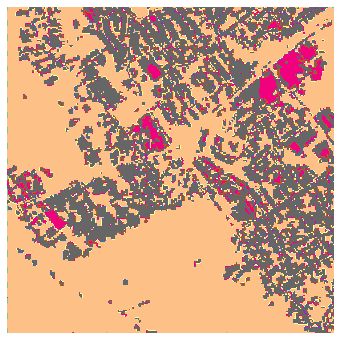

In [ ]:
cm='Accent' #'nipy_spectral_r'
f,axs = plt.subplots(1,1,figsize=(6,6))
msk.show(figsize=(5,5), alpha=1.,cmap=cm,ax=axs)
# msk2.show(figsize=(5,5), alpha=1.,cmap=cm,ax=axs[1])
np.unique(tensor(msk),return_counts=True)#,np.unique(tensor(msk2),return_counts=True)

In [ ]:
#Tensor mask with coded values (0,1,2,3)
tensor(msk)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 1, 0, 0],
        [0, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 1, 1,  ..., 3, 1, 1],
        [0, 1, 1,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 1, 1, 1]], dtype=torch.uint8)

In [ ]:
tensor(msk2)

tensor([0.0025, 0.6219, 0.0319, 0.3437])

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'0_0_No_Data': 0, '1_1_Land': 1, '2_250_Non_Resi_BU': 2, '3_255_Resi_BU': 3}

In [ ]:
# no_data_code = name2id['3_0_No_Data']
# no_data_code

## Calculating per image class proprtions for regression task


In [ ]:
# def build_proportions_df(fnames,preds=None):
#   cols=['image_name','mask_name',0,1,250,255,'bi_prop','250_Non_Resi_BU','255_Resi_BU']
#   if(preds!=None):
#     cols=['image_name','mask_name',0,1,250,255,'bi_prop','250_Non_Resi_BU','255_Resi_BU','pred_0','pred_1','pred_250','pred_255']
  
#   reg_df=pd.DataFrame(columns=cols)

#   for fn in fnames:
#     img_fn = fn.name
#     mask = get_matching_mask_path(img_fn,esm_aligned)
#     msk_fn = mask.split('/')[-1]
#     with rio.open(mask) as fmsk:
#       classes,counts = np.unique(fmsk.read(1),return_counts=True)
#       cnt = {cl:cn for (cl,cn) in zip(classes,counts)}
#       cnt['image_name']=img_fn
#       cnt['mask_name']=msk_fn
#       total=sum(counts)
#       a,b=0,0
#       if(250 in cnt):
#         a=cnt[250]
#       if(255 in cnt):
#         b=cnt[255]
#       fg_classes=a+b
#       cnt['250_Non_Resi_BU']=a/total
#       cnt['255_Resi_BU']=b/total
#       cnt['bi_prop']=fg_classes/total
#       reg_df=reg_df.append(cnt,ignore_index=True)
#   return reg_df

# orig_prop_df = build_proportions_df(fnames)
# orig_prop_df

In [ ]:
# orig_prop_df.describe()

## Metrics: IoU (Jaccard Index) ,Dice Score , Accuracy

In [ ]:
# def overall_acc(inp, targ):
#   '''
#   Overall pixel accuracy (not a good metric...)
#   '''
#   hist = prep_hist(inp,targ)
#   return overall_pixel_accuracy(hist)

In [ ]:
# def per_cls_acc(inp, targ):
#   '''
#   Per class pixel accuracy (not a bad metric...)
#   '''
#   hist = prep_hist(inp,targ)
#   return per_class_pixel_accuracy(hist)

In [ ]:
# def iou(inp, targ):
#   '''
#   IoU - Intersection over Union , Jaccard index
#   '''
#   hist = prep_hist(inp,targ)
#   return jaccard_index(hist)

In [ ]:
# def dice(inp, targ):
#   '''
#   Calculates the Dice coefficient between two images
#   '''
#   hist = prep_hist(inp,targ)
#   return dice_coefficient(hist)

In [ ]:
# def foreground_acc(inp, targ, bkg_idx=1, axis=1):
#     "Computes non-background accuracy for multiclass segmentation without the background class" 
#     targ = cast(targ.squeeze(1), TensorBase)
#     mask = targ != bkg_idx
#     return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()

## A Combined Loss function

A combined loss DiceLoss + Focal loss, that takes care of the class imbalance in the dataset https://docs.fast.ai/losses.html

Tuning the "gamma" and "alpha" hyperparams is critical.

FocalLoss: https://amaarora.github.io/2020/06/29/FocalLoss.html

Inspiration from this paper:
[Unified Focal loss: Generalising Dice and cross entropy-based losses to handle class imbalanced medical image segmentation](https://paperswithcode.com/paper/a-mixed-focal-loss-function-for-handling )


Code is at: `libs.multichannel.py`

In [ ]:
#Training images dir
TRAIN = s2_resized

## Augmentations

Required for multi channel images (and their masks) using [Albumenations](https://albumentations.ai/docs/examples/example_kaggle_salt/#Using-Albumentations-for-a-semantic-segmentation-task)

In [ ]:
#DEBUG / TEST trying to apply the dataset statistics values
# stats_mean_df = pd.read_csv('stats_mean_df.csv',index_col=0,header=0)
# stats_std_df  = pd.read_csv('stats_std_df.csv',index_col=0,header=0)

# means=list(stats_mean_df.mean().values)
# stds=list(stats_std_df.mean().values)
# s2_stats = (means,stds)

In [ ]:
#TODO move to multichannel.py
#Trying Albumenations as regular torch Augmentations support only 3 channels
import albumentations as A
width=300
height=300
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x

        # for albumentations to work correctly, the channels must be at the last dimension
        aug = self.aug(image=np.array(img.permute(1,2,0)), mask=np.array(mask))
        return TensorImage(aug['image'].transpose(2,0,1)), TensorMask(aug['mask'])

ppp=0.5
#From https://albumentations.ai/docs/examples/example_kaggle_salt/#Using-Albumentations-for-a-semantic-segmentation-task
#Half size is a popular choice of augmenation for segmentation tasks
aug_pipe = A.Compose([
                      # A.RandomSizedCrop(min_max_height=(150, 150), height=height, width=width, p=ppp),
    # A.PadIfNeeded(min_height=height, min_width=width, p=1),
    A.VerticalFlip(p=ppp),
    # A.RandomRotate90(p=ppp),
    A.RandomBrightnessContrast(p=ppp)]
    )


# Create our class with this aug_pipe
aug = SegmentationAlbumentationsTransform(aug_pipe)


In [ ]:
augs_list = []
for a in aug_pipe:
  augs_list.append(a.__class__.__name__)
augs_list

['VerticalFlip', 'RandomBrightnessContrast']

## L1 and MSE Losses

In [ ]:

# # Cell
# class BaseLoss():
#     "Same as `loss_cls`, but flattens input and target."
#     activation=decodes=noops
#     def __init__(self, loss_cls, *args, axis=-1, flatten=True, floatify=False, is_2d=True, **kwargs):
#         store_attr("axis,flatten,floatify,is_2d")
#         self.func = loss_cls(*args,**kwargs)
#         functools.update_wrapper(self, self.func)

#     def __repr__(self): return f"FlattenedLoss of {self.func}"
#     @property
#     def reduction(self): return self.func.reduction
#     @reduction.setter
#     def reduction(self, v): self.func.reduction = v

#     def _contiguous(self,x):
#         return TensorBase(x.transpose(self.axis,-1).contiguous()) if isinstance(x,torch.Tensor) else x

#     def __call__(self, inp, targ, **kwargs):
#         inp,targ  = map(self._contiguous, (inp,targ))
#         # print('INP>>>>>>>>>>>>',inp)
#         # print('TGT>>>>>>>>>>>>',targ)
#         if self.floatify and targ.dtype!=torch.float16: targ = targ.float()
#         if targ.dtype in [torch.int8, torch.int16, torch.int32]: targ = targ.long()
#         if self.flatten: inp = inp.view(-1,inp.shape[-1]) if self.is_2d else inp.view(-1)
#         return self.func.__call__(inp, targ.view(-1) if self.flatten else targ, **kwargs)

#     def to(self, device):
#         if isinstance(self.func, nn.Module): self.func.to(device)

# # Cell
# @use_kwargs_dict(reduction='mean')
# def MSELossFlat1(*args, axis=-1, floatify=True, **kwargs):
#     "Same as `nn.MSELoss`, but flattens input and target."
#     return BaseLoss(nn.MSELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)








## Hyperparams

In [ ]:
####################################
### MSE Loss (for regresssion)   ###
####################################
# loss_fn=MSELossFlat1(reduction='sum')
loss_fn=MSELossFlat()
# loss_fn=L1LossFlat()

####################################
### Combined Focal and Dice Loss ###
####################################
#======================================================================================
#GREAT RESULTS: |1. alpha=0.1,gamma=6
#======================================================================================
# loss_fn=CombinedLoss(alpha=0.1,gamma=6)

#######################
###  DiceLoss  Only ###
#######################
#loss_fn = DiceLoss(reduction="mean")
#Very bad - no learning at all

######################
### FocalLoss Only ###
######################
#axis=1,gamma=2.0
# loss_fn=FocalLossFlat(axis=1,gamma=6)
#although getting very low losses of ~0.06 - this is sometimes missing entire classes - and giving an overall lower scores
# when gamm is default , 2.0 - this is same as CE - it totally mixes entire classes (switches the pred of class 1 with 250)

#################
### CELoss ###
#################
#pass weights of each class from the EDA
# weights = torch.tensor([1e-07,0.70,0.05,0.25]).cuda()
# loss_fn = CrossEntropyLossFlat(weight=weights, axis=1)
# loss_fn=CrossEntropyLossFlat(axis=1) #Show that this is not a good LOSS for segmentation (without weights at least)
# RESULTS: cross-entropy is segmenting too small areas and has the worst scores performance (which makes sense for imbalanced dataset)
# it totally mixes entire classes (switches the pred of class 1 with 250)

In [ ]:
#Other hyper parameters

model='unet_fastai_reg'

#DataLoader and Learner 
batch_size=15
num_epochs=200
arch= resnet34 #deeplabv3_resnet50 # resnet34 # #resnet34
opt=ranger #SGD #ranger #Adam
#based on feature selection in EDA
#channels=[13,14,15] #crashes when 15 is added in Trio
# pretrained=True

pretrained=False #can be True only if using 3 channels
channels=None
# normalize_input=False
normalize_input=True
num_chan=len(channels) if channels!=None else None

# lr=0.0 #will be automatically set by lr_find
valid_pct=0.20

#AUGMENTATIONS
item_augms = aug

# batch_augms = Normalize.from_stats(*s2_stats) #[RandomHorizontalFlip(p=ppp),RandomVerticalFlip(p=ppp)]
batch_augms=None #Normalize.from_stats(*s2_stats)#None


In [ ]:
def MultiChannelImageBlock(cls=MultiChannelTensorImage, chans=None): 
    "By default all channels are loaded"
    return TransformBlock(partial(cls.create, chans=chans))
    
    
class MCISegmentationDataLoaders(DataLoaders):
    '''
    A wrapper around several `DataLoader`s with factory methods for segmentation of multi channel tiff images
    This is an extension to fastai's SegmentationDataLoaders (https://docs.fast.ai/vision.data.html#SegmentationDataLoaders )
    to support multi channel Tiff images.
    '''
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func_segm(cls, path, fnames, label_func, chans=None, 
                         extensions=['.tif'], valid_pct=0.2, seed=None, 
                         codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        '''
        Create from list of `fnames` in `path`s with `label_func`.
        This method creates a new fastai (PyTorch) data loader from two directories of images and matching masks,
        It was needed to handle the Sentinel2 multi channel Tiff images (Default implementation supports RGB with 3 channels only)
        It is basically a copy of the original fastai class method: https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L180 
        except if it using the custom `MultiChannelImageBlock` that was defined above.
        - path (str): full path to train images
        - bs (int): the batch size to use with the data loader - default 5
        - codes (list): a list of all possible target classes in the mask
        - fnames (list): a list of all the image file names without their path
        - label_func (func): a function that returns the matching mask of an image
        - valid_pct (float 0 to 1): the precentage of images for validation during training - default 0.1
        - extensions (list):  list of image file fexts to use when loading image and mask files - default ['.tif']
        - channels (list of integers): the channels to read from the input image, and int from 1 to 12
        - seed (int): random seed for reproducing results (for numpy pytorch)
        - item_tfms (list of transforms): list of transformations (augmentations)  - (fastai) Item transforms are for collating and preparing for a batch and theyÃ¢â‚¬â„¢re run on the CPU
        - batch_tfms (list of transforms): list of transformations (augmentations) -  (fastai) Batch transforms are applied after everything is resized and batched up and done on the GPU
        '''        
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), 
                                  #  MaskBlock(codes=codes)),
                                   RegressionBlock(len(codes))),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [ ]:
TRAIN = s2_resized

dl_train = MCISegmentationDataLoaders.from_label_func_segm(chans=channels,path=TRAIN, bs=batch_size, codes=codes,
                                                   fnames=get_files(TRAIN, extensions=['.tif'], recurse=False),
                                                   #For regression use get_msk2
                                                   label_func = lambda o: get_msk2(o.name,esm_aligned, mask_vals),
                                                   #For segmentation use get_msk2
                                                  #  label_func = lambda o: get_msk(o.name,esm_aligned, mask_vals),
                                                   item_tfms=item_augms,batch_tfms=batch_augms,
                                                   valid_pct=valid_pct)

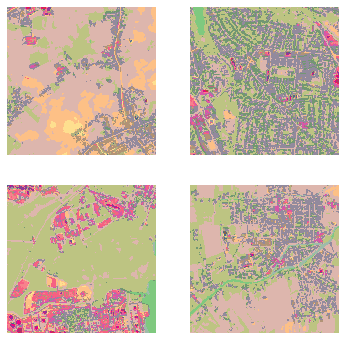

In [ ]:
cm='Accent'
dl_train.show_batch(max_n=4,figsize=(6,6),cmap=cm)

In [ ]:
print(dl_train.train.items[0], dl_train.valid.items[0])
print(len(dl_train.valid.items),len(dl_train.train.items))


/content/s2_resized/R_2_191.tif /content/s2_resized/R_4_345.tif
130 520


In [ ]:
# #export
# from fastai.torch_basics import *
# from fastai.callback.hook import *

In [ ]:
# #export 
# def _get_sz_change_idxs(sizes):
#     "Get the indexes of the layers where the size of the activation changes."
#     feature_szs = [size[-1] for size in sizes]
#     sz_chg_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
#     return sz_chg_idxs

In [ ]:
# #export 
# class UnetBlock(Module):
#     "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
#     @delegates(ConvLayer.__init__)
#     def __init__(self, up_in_c, x_in_c, hook, final_div=True, blur=False, act_cls=defaults.activation,
#                  self_attention=False, init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
#         self.hook = hook
#         self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, act_cls=act_cls, norm_type=norm_type)
#         self.bn = BatchNorm(x_in_c)
#         ni = up_in_c//2 + x_in_c
#         nf = ni if final_div else ni//2
#         self.conv1 = ConvLayer(ni, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
#         self.conv2 = ConvLayer(nf, nf, act_cls=act_cls, norm_type=norm_type,
#                                xtra=SelfAttention(nf) if self_attention else None, **kwargs)
#         self.relu = act_cls()
#         # apply_init(nn.Sequential(self.conv2, self.conv2), init)
#         apply_init(nn.Sequential(self.conv1, self.conv2), init)

#     def forward(self, up_in):
#         s = self.hook.stored
#         up_out = self.shuf(up_in)
#         ssh = s.shape[-2:]
#         if ssh != up_out.shape[-2:]:
#             up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
#         cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
#         return self.conv2(self.conv1(cat_x))

In [ ]:
# #export 
# class DynamicUnet(SequentialEx):
#     "Create a U-Net from a given architecture."
#     def __init__(self, encoder, n_out, img_size, blur=False, blur_final=True, self_attention=False,
#                  y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
#                  init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
#         print('WHOOOOOOOOOOOOA! custom it is then')
#         imsize = img_size
#         sizes = model_sizes(encoder, size=imsize)
#         sz_chg_idxs = list(reversed(_get_sz_change_idxs(sizes)))
#         self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
#         x = dummy_eval(encoder, imsize).detach()

#         ni = sizes[-1][1]
#         middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
#                                     ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
#         x = middle_conv(x)
#         layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

#         for i,idx in enumerate(sz_chg_idxs):
#             not_final = i!=len(sz_chg_idxs)-1
#             up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
#             do_blur = blur and (not_final or blur_final)
#             sa = self_attention and (i==len(sz_chg_idxs)-3)
#             unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
#                                    act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
#             layers.append(unet_block)
#             x = unet_block(x)

#         ni = x.shape[1]
#         if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
#         layers.append(ResizeToOrig())
#         if last_cross:
#             layers.append(MergeLayer(dense=True))
#             ni += in_channels(encoder)
#             layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
#         # layers += [ConvLayer(ni, n_out, ks=1, act_cls=None, norm_type=norm_type, **kwargs)]
#         layers += [ConvLayer(ni, 2*n_out, ks=1, act_cls=None, norm_type=norm_type, **kwargs)]
#         #TODO change the output to be C x 4 to predict the count of every class only!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#         # print(ni,n_out)
#         # layers += [nn.Flatten(**kwargs)]
#         # layers += [nn.Linear(imsize[0], n_out, **kwargs)]
#         apply_init(nn.Sequential(layers[3], layers[-2]), init)
#         #apply_init(nn.Sequential(layers[2]), init)
#         if y_range is not None: layers.append(SigmoidRange(*y_range))
#         # layers.append(ToTensorBase())
#         super().__init__(*layers)

#     def __del__(self):
#         if hasattr(self, "sfs"): self.sfs.remove()

In [ ]:
# m = resnet50()
# m = resnet34()
# m = nn.Sequential(*list(m.children())[:-2])
# tstmodel = DynamicUnet(m, 4, (99,99), norm_type=None)
# x = cast(torch.randn(2, 3, 99, 99), TensorImage)
# y = tstmodel(x)
# test_eq(y.shape, [2, 8, 99,99])

In [ ]:
# #From here: https://github.com/fastai/fastai/blob/62e608e9350858e8a10292b997482ee5d9c072fa/fastai/vision/learner.py

# # Cell
# def _add_norm(dls, meta, pretrained):
#     if not pretrained: return
#     stats = meta.get('stats')
#     if stats is None: return
#     if not dls.after_batch.fs.filter(risinstance(Normalize)):
#         dls.add_tfms([Normalize.from_stats(*stats)],'after_batch')
        
# _default_meta    = {'cut':None, 'split':default_split}

# # Cell
# @delegates(models.unet.DynamicUnet.__init__)
# def create_unet_model(arch, n_out, img_size, pretrained=True, cut=None, n_in=3, **kwargs):
#     '''
#     Create custom unet architecture
#     '''
#     meta = model_meta.get(arch, _default_meta)
#     body = create_body(arch, n_in, pretrained, ifnone(cut, meta['cut']))
#     #local copy
#     model = DynamicUnet(body, n_out, img_size, **kwargs)
#     # model = models.unet.DynamicUnet(body, n_out, img_size, **kwargs)

#     return model

# # Cell
# @delegates(create_unet_model)
# def unet_learner(dls, arch, normalize=True, n_out=None, pretrained=True, config=None,
#                  # learner args
#                  loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
#                  model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
#                  # other model args
#                  **kwargs):
#     "Build a unet learner from `dls` and `arch`"
#     print('YEAHHHHHHHHHHHHHHHHHHHHHHH custom it is then...')
#     if config:
#         warnings.warn('config param is deprecated. Pass your args directly to unet_learner.')
#         kwargs = {**config, **kwargs}

#     meta = model_meta.get(arch, _default_meta)
#     if normalize: _add_norm(dls, meta, pretrained)

#     n_out = ifnone(n_out, get_c(dls))
#     assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
#     img_size = dls.one_batch()[0].shape[-2:]
#     assert img_size, "image size could not be inferred from data"
#     model = create_unet_model(arch, n_out, img_size, pretrained=pretrained, **kwargs)
    
#     splitter=ifnone(splitter, meta['split'])
#     learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
#                    metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
#                    moms=moms)
#     if pretrained: learn.freeze()
#     # keep track of args for loggers
#     store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
#     return learn

## Transfer Learning from the trained UNET 

https://docs.fast.ai/vision.learner.html#unet_learner

In [ ]:
!cp -n '/content/drive/MyDrive/2022/S1/3624_Final_Project/models/last_model.pth' .

In [ ]:
# !ls last_model.pth

In [ ]:
final_states_dict_file = Path('last_model.pth')
INFERECE_MODE=final_states_dict_file.is_file()
INFERECE_MODE

True

In [ ]:
if num_chan==None:
  num_chan=15
nn_out=len(codes)
learn = unet_learner(dl_train, n_in=num_chan, n_out=nn_out,pretrained=pretrained,model_dir='../../models/',
                    arch=arch,
                    metrics=[mse],
                    # self_attention=True,
                    loss_func=loss_fn,
                    act_cls = nn.ReLU,#Mish,
                    opt_func=opt,
                    normalize=normalize_input).to_fp16()

if(INFERECE_MODE):
  print('Inference mode: loading model states dict...')
  learn.load_state_dict(torch.load(final_states_dict_file),strict=False)


Inference mode: loading model states dict...


In [ ]:
learn.freeze()

In [ ]:
os.chdir('/content/crfasrnn_pytorch/')
# !pwd
# !git clone https://github.com/sadeepj/crfasrnn_pytorch.git
# !pip install -r requirements.txt
# !wget https://github.com/sadeepj/crfasrnn_pytorch/releases/download/0.0.1/crfasrnn_weights.pth 
# !python -m  /content/crfasrnn_pytorch/crfasrnn/dist/permuto_cpp-0.0.0-py3.7-linux-x86_64.egg
# !python setup.py install
# !python run_demo.py
# restart runtime !!!
# from crfasrnn import util
from crfasrnn.crfrnn import CrfRnn
from crfasrnn.crfasrnn_model import CrfRnnNet


# model = CrfRnnNet()
# crfrnn = CrfRnn(num_labels=nn_out, num_iterations=10)


In [ ]:
def freeze_layers(learn):
  for p in learn.model.layers.named_parameters():
    p[1].requires_grad=False
# freeze_layers(learn)
learn.freeze()

img_size=300
new_lin = nn.Sequential(
    nn.Flatten(),
    nn.Linear( nn_out*img_size**2, nn_out),
    # nn.Softmax(dim=1)
    # CrfRnn(num_labels=nn_out, num_iterations=10)
    nn.ReLU()
    # CrfRnnNet()
)
# learn.model.layers
learn.model.layers.append(new_lin)
print('model frozen, added new output layer')
learn.model.layers[-1]
# pret_model['new_custom_layer']

model frozen, added new output layer


Sequential(
  (0): CrfRnnNet(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
    (relu1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_3)

In [ ]:
learn.summary()

TypeError: ignored

In [ ]:
from datetime import datetime
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 26/04/2022 18:00:25


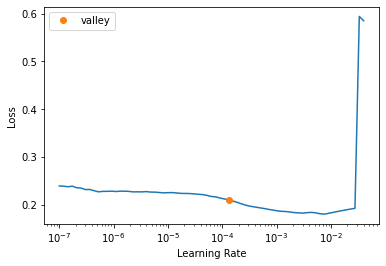

In [ ]:
# if(INFERECE_MODE):
#   print('Inference mode: skipping training, loading model states dict...')
#   learn.load_state_dict(torch.load(final_states_dict_file))
# else:
# learn.unfreeze()
l = learn.lr_find()

In [ ]:
min_grad_lr = l.valley
print(min_grad_lr)

0.00013182566908653826


In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(num_epochs,min_grad_lr,
#                     cbs=[SaveModelCallback(),
#                     EarlyStoppingCallback(monitor='valid_loss', patience=15)])

In [ ]:
learn.fit_flat_cos(num_epochs,lr=min_grad_lr,
                        cbs=[SaveModelCallback(),
                        EarlyStoppingCallback(monitor='valid_loss', patience=6),
                        ReduceLROnPlateau( patience=2)])
  


epoch,train_loss,valid_loss,mse,time
0,0.145652,0.130605,0.035209,00:21
1,0.105900,0.077536,0.013826,00:20
2,0.089504,0.071051,0.011599,00:20
3,0.078321,0.071646,0.011733,00:20
4,0.071911,0.070062,0.011272,00:20
5,0.070907,0.069510,0.011019,00:20
6,0.067515,0.078365,0.013213,00:20
7,0.062888,0.067245,0.010231,00:20
8,0.057605,0.067608,0.010421,00:20
9,0.054274,0.067843,0.010332,00:20


Better model found at epoch 0 with valid_loss value: 0.130604550242424.
Better model found at epoch 1 with valid_loss value: 0.07753637433052063.
Better model found at epoch 2 with valid_loss value: 0.07105051726102829.
Better model found at epoch 4 with valid_loss value: 0.0700618177652359.
Better model found at epoch 5 with valid_loss value: 0.0695100724697113.
Better model found at epoch 7 with valid_loss value: 0.06724512577056885.
Epoch 9: reducing lr to 1.3182566908653825e-05
Better model found at epoch 11 with valid_loss value: 0.06366240233182907.
Epoch 13: reducing lr to 1.3182566908653825e-05
Better model found at epoch 14 with valid_loss value: 0.06329464167356491.
Better model found at epoch 16 with valid_loss value: 0.0618254579603672.
Better model found at epoch 17 with valid_loss value: 0.06157916039228439.
Epoch 19: reducing lr to 1.3182566908653825e-05
Epoch 21: reducing lr to 1.3182566908653825e-05
Better model found at epoch 23 with valid_loss value: 0.05947732552886

In [ ]:
#TODO this is not showing the best values -  just the last ones...

log = learn.recorder.log
log

(#5) [59,0.01966659352183342,0.055413469672203064,0.0065905312076210976,'00:20']

In [ ]:
learn.recorder.log

(#5) [59,0.01966659352183342,0.055413469672203064,0.0065905312076210976,'00:20']

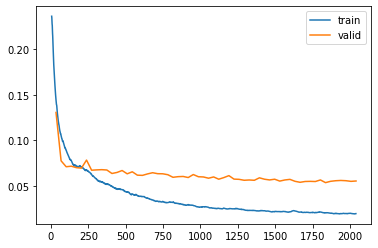

In [ ]:
learn.recorder.plot_loss()

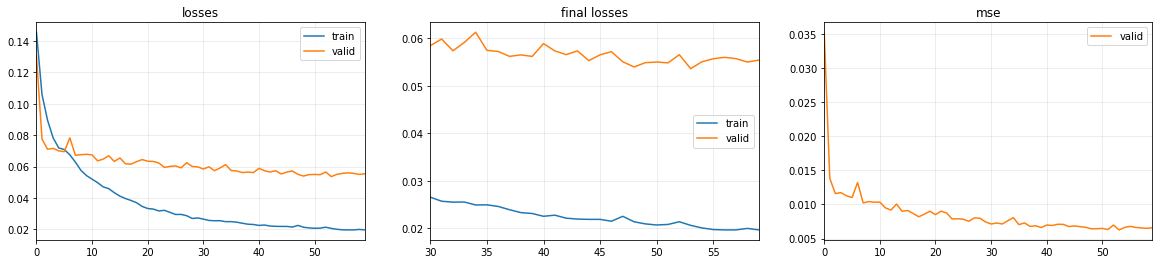

In [ ]:
learn.recorder.plot_metrics()

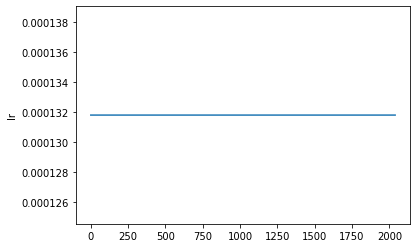

In [ ]:
learn.recorder.plot_sched()

In [ ]:
# interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

## Store results of experiments and save to a log


In [ ]:

cols=['datetime','model','num_epochs','loss_fn','batch_size',
    'arch','optim','channels','pretrained','lr','valid_pct',
    # 'trn_loss','val_loss','acc','per_cls_acc','IoU','Dice','DiceMulti', 'foreground_acc','item_augs','batch_augs','epoch_time']
    'trn_loss','val_loss','mse','epoch_time']
results=pd.DataFrame(columns=cols)
if loss_fn.__class__.__name__.startswith('CombinedLoss'):
  loss_display = loss_fn.display()
else:
  loss_display=(loss_fn.__class__.__name__)
new_expriment_log=[dt_string,model,log[0],loss_display,batch_size,
    arch.__name__,opt.__name__,channels,pretrained,min_grad_lr,valid_pct,
    log[1],log[2],log[3],log[-1]]

results.loc[len(results)] = new_expriment_log
results

,datetime,model,num_epochs,loss_fn,batch_size,arch,optim,channels,pretrained,lr,valid_pct,trn_loss,val_loss,mse,epoch_time
0,26/04/2022 18:00:25,unet_fastai_reg,59,BaseLoss,15,resnet34,ranger,None,False,0.000132,0.2,0.019667,0.055413,0.006591,00:20


In [ ]:
if(INFERECE_MODE):
  print('Inference mode')
else:
  results.to_csv('logs/results_log.csv', mode='a', index=False, header=False)


Inference mode


## Inference - Display some results

In [ ]:
# Learner.dls = dl_train

In [ ]:
#TODO see if we can plot the image behind the masks...
cm='Accent' #'nipy_spectral_r'
# learn.show_results(max_n=6, figsize=(6,16),cmap=cm)

## Compare class proprtions , similiarity of original and generated masks

First "predict" a mask for all the **training** data

In [ ]:
PREDS_DIR= 'preds'

In [ ]:
train_fnames = get_image_files(s2_resized)

dl = learn.dls.test_dl(train_fnames)
preds = learn.get_preds(dl=dl)
preds[0].shape


torch.Size([650, 4])

In [ ]:
res = learn.get_preds(with_input=True,with_decoded=True)
preds_decoded = res[2]
preds_decoded.shape

torch.Size([130, 4])

In [ ]:
assert(sum(preds_decoded[55]))
preds_decoded[55]

tensor([0.0058, 0.6516, 0.0178, 0.3249])

In [ ]:
#TODO move to `libs`
def calc_props(inp,decode=False,input_preds=False):
  '''
  Calculates the propertions of the forground classes given a mask tensor
  '''
  if(not input_preds):
    decoded_classes,counts = np.unique(inp,return_counts=True)
    if(decode):
      decoded_classes = [mask_vals[c] for c in decoded_classes]

    cnt = {cl:cn for (cl,cn) in zip(decoded_classes,counts)}
    if(len(cnt)<4):
      if(0 not in cnt):
        cnt[0]=0.
      if(1 not in cnt):
        cnt[1]=0.
      if(250 not in cnt):
        cnt[250]=0.
      if(255 not in cnt):
        cnt[255]=0.

  else:
    #TODO too hard coded !!!
    cnt = {cl:int(cn.item()*90000) for (cl,cn) in zip([0,1,250,255],inp)}
    counts = [val for val in cnt.values()]

  total=sum(counts)
  a,b=0.,0.
  if(250 in cnt):
    a=cnt[250]
  if(255 in cnt):
    b=cnt[255]
  fg_classes=a+b
  cnt['250_prop']=float(a/total)
  cnt['255_prop']=float(b/total)
  cnt['BU_prop']=float(fg_classes/total)

  return cnt


def build_proportions_df(fnames,preds,mask_dir):
  '''
  Builds a proprtions dataframe for a list of image files and their predicted masks
  by counting the per class pixels, and calculating proprtions of fourgournd classes, 250 and 255,
  vs the others.
  '''
  numeric_cols = [0,1,250,255,'BU_prop','250_prop','255_prop']
  str_cols=['type','image_name','mask_name']

  reg_df=pd.DataFrame(columns=str_cols+numeric_cols)
  for fn,pred_msk in tqdm(zip(fnames,preds)):
    img_fn = fn.name
    mask = get_matching_mask_path(img_fn,mask_dir)
    msk_fn = mask.split('/')[-1]
    with rio.open(mask) as fmsk:
      #orig
      cnt1 = calc_props(fmsk.read(1))
      cnt1['type']='ORIG'

      #pred
      pred_arx = pred_msk#.argmax(dim=0)
      cnt2 = calc_props(pred_arx,input_preds=True)
      cnt2['type']='PRED'

      #diff
        
      cnt3 = {}
      for i in numeric_cols:
        cnt3[i]=float(abs(cnt1[i]-cnt2[i]))
      cnt3['type']='DIFF'
    
      for c in [cnt1,cnt2,cnt3]:
        c['image_name']=img_fn
        c['mask_name']=msk_fn

      reg_df=reg_df.append(cnt1,ignore_index=True)
      reg_df=reg_df.append(cnt2,ignore_index=True)
      reg_df=reg_df.append(cnt3,ignore_index=True)
      
      
  return reg_df

# orig_prop_df = build_proportions_df(fnames)
# orig_prop_df

In [ ]:
pred_prop_df = build_proportions_df(train_fnames,preds_decoded,esm_aligned)
pred_prop_df.head(12)

0it [00:00, ?it/s]

,type,image_name,mask_name,0,1,250,255,BU_prop,250_prop,255_prop
0,ORIG,R_7_654.tif,ESM_654.tif,320,65941,987,22752,0.263767,0.010967,0.252800
1,PRED,R_7_654.tif,ESM_654.tif,4712,41586,23438,20261,0.485561,0.260431,0.225130
2,DIFF,R_7_654.tif,ESM_654.tif,4392.0,24355.0,22451.0,2491.0,0.221794,0.249464,0.027670
3,ORIG,R_7_635.tif,ESM_635.tif,228,55969,2869,30934,0.375589,0.031878,0.343711
4,PRED,R_7_635.tif,ESM_635.tif,232,60972,4824,23969,0.319933,0.053602,0.266331
5,DIFF,R_7_635.tif,ESM_635.tif,4.0,5003.0,1955.0,6965.0,0.055656,0.021724,0.077380
6,ORIG,R_7_662.tif,ESM_662.tif,948,29568,7986,51498,0.660933,0.088733,0.572200
7,PRED,R_7_662.tif,ESM_662.tif,2113,47918,5566,34401,0.444088,0.061846,0.382242
8,DIFF,R_7_662.tif,ESM_662.tif,1165.0,18350.0,2420.0,17097.0,0.216846,0.026888,0.189958
9,ORIG,R_5_471.tif,ESM_471.tif,428,67370,7145,15057,0.246689,0.079389,0.167300


In [ ]:
# pred_prop_df[pred_prop_df['type']=='Pred'].describe()
pred_prop_df.describe()

,BU_prop,250_prop,255_prop
count,390.000000,390.000000,390.000000
mean,0.249087,0.054376,0.209985
std,0.145387,0.061015,0.126234
min,0.000063,0.000000,0.000385
25%,0.172712,0.009629,0.126938
50%,0.225241,0.031561,0.191815
75%,0.331639,0.079656,0.286763
max,0.719867,0.298867,0.613667


In [ ]:
# plot_final_results(train_fnames,preds,pred_prop_df,s2_resized,esm_aligned,show_every=65)

In [ ]:
# df_new_mask_class_counts = pd.DataFrame(columns=['0','1','2','3'])
# for pred_mask in preds[0]:
#   pred_arx = pred_mask.argmax(dim=0)
#   add_cls_counts(df_new_mask_class_counts,pred_arx,classes_dic={'0':0,'1':0,'2':0,'3':0})

In [ ]:
# om=pd.read_csv('orig_masks_bu_area.csv',index_col=0,header=None)
# om=pd.read_csv('orig_masks_bu_area_w_nodata.csv',index_col=0,header=None)


In [ ]:
# nm=get_bu_area_ratio(df_new_mask_class_counts,with_no_data=True)
# nm=get_bu_area_ratio(df_new_mask_class_counts)

# f,ax1 = plt.subplots(1,1,figsize=(12,4))
# plot_hist(om,None,ax1,'Red',lbl='Orig')
# plot_hist(nm,'Orig and Pred Masks Ratio of Built-UP Areas',ax1,'Blue',lbl='Pred')
# plt.show()

In [ ]:
# f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

# df_orig_mask_class_counts = pd.read_csv('df_orig_mask_class_counts.csv',index_col=0,header=None)

# plot_bar(df_orig_mask_class_counts,'Orig Mask Class Proportions',ax1)
# annotate(ax1)

# plot_bar(df_new_mask_class_counts,'Pred Mask Class Proportions',ax2)
# annotate(ax2)
# plt.show()

## Inference on unseen images

+ Saving predictions to a folder

In [ ]:
test_fnames = get_image_files(S2_TEST_DIR)

dl = learn.dls.test_dl(test_fnames)
test_preds = learn.get_preds(dl=dl,with_decoded=True)
test_preds[0].shape

torch.Size([50, 4])

In [ ]:
test_preds_decoded = test_preds[2]
test_preds_decoded.shape

torch.Size([50, 4])

In [ ]:
pred_test_prop_df = build_proportions_df(test_fnames,test_preds_decoded,ESM_TEST_DIR)
pred_test_prop_df.head(12)

0it [00:00, ?it/s]

,type,image_name,mask_name,0,1,250,255,BU_prop,250_prop,255_prop
0,ORIG,R_3_254.tif,ESM_254.tif,241,69946,1011,18802,0.220144,0.011233,0.208911
1,PRED,R_3_254.tif,ESM_254.tif,0,68598,0,19467,0.221053,0.000000,0.221053
2,DIFF,R_3_254.tif,ESM_254.tif,241.0,1348.0,1011.0,665.0,0.000908,0.011233,0.012142
3,ORIG,R_6_566.tif,ESM_566.tif,322,68817,273,20588,0.231789,0.003033,0.228756
4,PRED,R_6_566.tif,ESM_566.tif,0,63193,2132,27949,0.322501,0.022857,0.299644
5,DIFF,R_6_566.tif,ESM_566.tif,322.0,5624.0,1859.0,7361.0,0.090713,0.019824,0.070889
6,ORIG,R_3_222.tif,ESM_222.tif,318,70119,718,18845,0.217367,0.007978,0.209389
7,PRED,R_3_222.tif,ESM_222.tif,0,68686,0,15820,0.187206,0.000000,0.187206
8,DIFF,R_3_222.tif,ESM_222.tif,318.0,1433.0,718.0,3025.0,0.030161,0.007978,0.022183
9,ORIG,R_4_398.tif,ESM_398.tif,292,61954,1493,26261,0.308378,0.016589,0.291789


In [ ]:
!rm -f preds/*.tif

In [ ]:
# plot_final_results(test_fnames,test_preds,pred_test_prop_df,S2_TEST_DIR,ESM_TEST_DIR)

We can see that when the color bars are higer than Dice~0.6 the quality of the preciction is not bad
The Absolute error is the sum of the error precentage for all classes
The Absolute Foreground error is the sum of the error precentage for 250,255
We can see for some images (such R_7_685.tif or R_1_61.tif), where the "no data" was covering some real 250 and 255 - the model was able to predict them quite well...

In [ ]:
#Save final model (~700MB)
# learn.save('last_model')


We are getting the same or better metric results as some relevant published papers, such as:
https://www.mdpi.com/2072-4292/13/12/2292/htm

Table 16. Global metrics for the experiment with UNet on UOS2 (UOS2 is made out of Sentinel-2 satellite imagery and uses 13 bands or channels per image).

| Experiment | 	OA | 	PA | 	UA | 	IoU | 	F1 | 
|------------|-----|-----|-----|------|------|
|Base|	0.647|	0.569|	0.428|	0.323|	0.489|
|6 bands|	0.569|	0.480|	0.373|	0.252|	0.420|
|13 bands|	0.589|	0.463|	0.371|	0.261|	0.412|


References:

Some code snippets and inspiration:

https://gist.github.com/jaeeolma/0846e03c0c3b613212f8ca5824ae47e0

https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Binary_Segmentation.ipynb

[Semantic Segmentation for Edge Detection](file:///C:/Users/liadl/Desktop/remotesensing-14-00613-v2.pdf)

Focal Loss paper : https://arxiv.org/pdf/1708.02002.pdf

Paper with metric results on S2: https://www.mdpi.com/2072-4292/13/12/2292/htm

Combined Focal and Dice loss: https://arxiv.org/abs/2102.04525
